# Persiapan Awal

## Library

In [1]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from textblob import Word
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, roc_auc_score
)

nltk.download('wordnet')
nltk.download('omw-1.4')
!pip install wordcloud
print("Semua library berhasil di-load.")

In [2]:
# Fungsi pembersihan (harus bisa menangani pd.Series/np.array)
def preprocessing_teks_lengkap(teks_series):
    # Konversi ke Series jika inputnya numpy array (terjadi saat prediksi)
    if not isinstance(teks_series, pd.Series):
        teks_series = pd.Series(teks_series)

    teks_bersih = teks_series.apply(lambda x: " ".join(w.lower() for w in str(x).split()))
    teks_bersih = teks_bersih.str.replace(r"[^\w\s]", "", regex=True)
    teks_bersih = teks_bersih.str.replace(r"\d", "", regex=True)
    teks_bersih = teks_bersih.apply(lambda x: " ".join(Word(i).lemmatize() for i in x.split()))

    return teks_bersih

# Buat object FunctionTransformer
text_cleaner = FunctionTransformer(preprocessing_teks_lengkap, validate=False)

print("Fungsi 'preprocessing_teks_lengkap' dan 'text_cleaner' siap digunakan.")

Fungsi 'preprocessing_teks_lengkap' dan 'text_cleaner' siap digunakan.


## Mount Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/Phishing_Email.csv", index_col=0)

## Inspeksi Awal Data

In [5]:
df.head()

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email


## Inspeksi Struktur Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18650 entries, 0 to 18650
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email Text  18634 non-null  object
 1   Email Type  18650 non-null  object
dtypes: object(2)
memory usage: 437.1+ KB


# Preprocessing

## Missing Values

In [7]:
df.isnull().sum()

,0
Email Text,16
Email Type,0


## Menghapus Baris dengan Data Hilang

In [8]:
df = df.dropna()

## Memeriksa dan Menghapus Data Duplikat

In [9]:
print(f"Jumlah baris sebelum cek duplikat: {len(df)}")

# Menghitung jumlah baris yang merupakan duplikat di kolom 'Email Text'
jumlah_duplikat = df.duplicated(subset=['Email Text']).sum()
print(f"Jumlah email teks yang duplikat: {jumlah_duplikat}")

# keep='first' berarti menyimpan baris pertama dan menghapus sisanya
df = df.drop_duplicates(subset=['Email Text'], keep='first')
print(f"Jumlah baris setelah menghapus duplikat: {len(df)}")

Jumlah baris sebelum cek duplikat: 18634
Jumlah email teks yang duplikat: 1097
Jumlah baris setelah menghapus duplikat: 17537


## Membersihkan Data

In [10]:
df = df[df['Email Text'].str.lower() != 'empty']

## Visualisasi Data (EDA)
Berikut adalah gambaran visual kata-kata yang sering muncul pada email Phishing vs Aman.

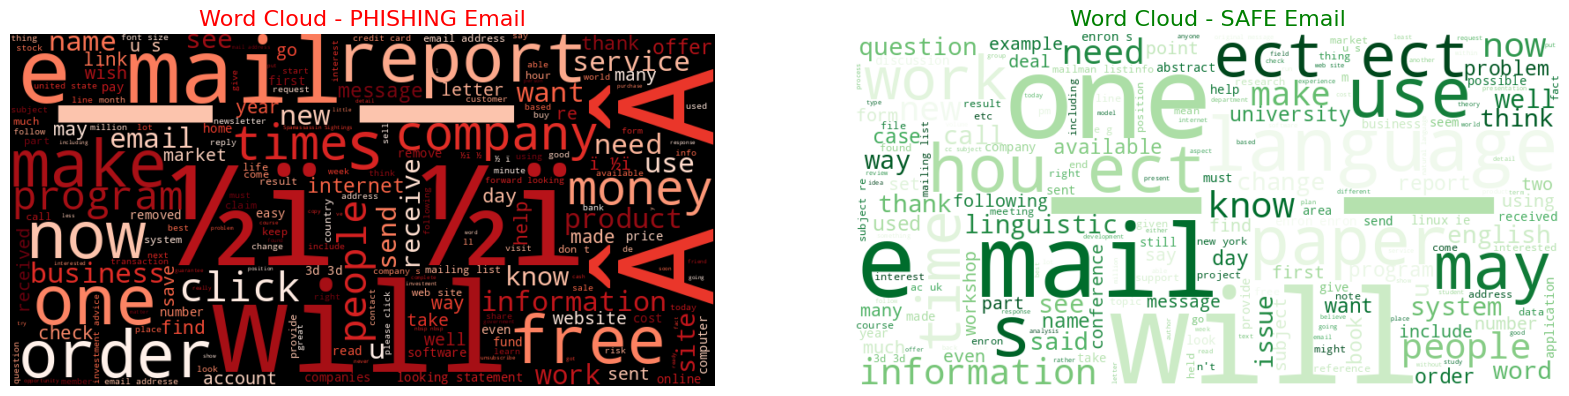

In [11]:
# --- EDA Tambahan: WordCloud ---
# Memvisualisasikan kata-kata yang paling sering muncul di Phishing vs Safe Email

# Filter data
phishing_text = " ".join(df[df['Email Type'] == 'Phishing Email']['Email Text'].astype(str))
safe_text = " ".join(df[df['Email Type'] == 'Safe Email']['Email Text'].astype(str))

# Setup Plot
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# WordCloud Phishing
wc_phishing = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(phishing_text)
ax[0].imshow(wc_phishing, interpolation='bilinear')
ax[0].set_title("Word Cloud - PHISHING Email", fontsize=16, color='red')
ax[0].axis('off')

# WordCloud Safe
wc_safe = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(safe_text)
ax[1].imshow(wc_safe, interpolation='bilinear')
ax[1].set_title("Word Cloud - SAFE Email", fontsize=16, color='green')
ax[1].axis('off')

plt.show()

## Label Encoding

In [12]:
mapping = {'Safe Email': 0, 'Phishing Email': 1}

df['email_type_encoded'] = df['Email Type'].map(mapping)

In [13]:
!pip install textblob
!pip install nltk

## Memisahkan Fitur (X) dan Target (Y)

In [14]:
X=df["Email Text"]
Y=df['email_type_encoded']

## DataFrame Final Setelah Preprocessing

## Membagi Data (Train-Test Split)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20, stratify=Y)

print(f"Data latih (X_train): {len(X_train)} baris")
print(f"Data uji (X_test): {len(X_test)} baris")

Data latih (X_train): 14028 baris
Data uji (X_test): 3508 baris


# Pemodelan dan Evaluasi

### Strategi Penanganan Data Tidak Seimbang (Imbalanced Data)

Dataset keamanan siber seperti *phishing* seringkali memiliki masalah ketidakseimbangan kelas (jumlah email aman jauh lebih banyak daripada email phishing). Jika dibiarkan, model akan cenderung bias memprediksi "Aman" demi mencapai akurasi tinggi semu.

Untuk mengatasi hal ini, kita menggunakan teknik **SMOTE (Synthetic Minority Over-sampling Technique)** di dalam pipeline.
* **Tujuan:** Menyeimbangkan proporsi data latih.
* **Cara Kerja:** SMOTE tidak sekadar menduplikasi data lama, melainkan membuat data sintetis baru berdasarkan tetangga terdekat (*k-nearest neighbors*) dari kelas minoritas (Phishing).
* **Penting:** SMOTE hanya diterapkan pada *Training Set* untuk mencegah kebocoran data (*data leakage*) ke *Test Set*.

In [16]:
# Persiapan Pipeline: Cleaning -> TF-IDF -> SMOTE -> Logistic Regression ---
# Menggunakan imblearn Pipeline agar SMOTE hanya dijalankan pada data latih (training fold) saat Cross-Validation
# Hal ini mencegah data leakage (kebocoran data) dari validasi set.

pipeline_final = ImbPipeline([
    ('cleaner', text_cleaner),  # Fungsi pembersihan teks yang sudah dibuat
    ('vectorizer', TfidfVectorizer(stop_words="english")),
    ('smote', SMOTE(random_state=20)), # Penanganan Imbalance
    ('classifier', LogisticRegression(random_state=20, max_iter=1000))
])

### Optimasi Hyperparameter & Pemilihan Metrik

Pada tahap ini, kita melakukan penyetelan parameter (*tuning*) menggunakan **GridSearchCV** dengan validasi silang (*Cross-Validation*).

**Mengapa F1-Score menjadi acuan utama?**
Dalam deteksi penipuan, sekadar "Akurasi" bisa menyesatkan.
* **Bahaya False Negative:** Jika email phishing dianggap aman, pengguna bisa tertipu (risiko tinggi).
* **Bahaya False Positive:** Jika email aman dianggap phishing, pengguna akan terganggu (masuk spam).

Oleh karena itu, kita mengoptimalkan **F1-Score**, yang merupakan rata-rata harmonik dari *Precision* dan *Recall*, untuk memastikan model tidak hanya menebak kelas mayoritas saja.

In [17]:
# --- 3. Definisi Hyperparameter untuk GridSearchCV ---
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)], # Coba unigram dan bigram
    'vectorizer__max_df': [0.7, 0.9],            # Abaikan kata yang terlalu sering muncul
    'vectorizer__min_df': [3, 5],                # Abaikan kata yang terlalu jarang muncul
    'classifier__C': [0.1, 1, 10, 100],          # Regularisasi Logistic Regression
    'classifier__solver': ['liblinear', 'lbfgs'] # Algoritma optimasi
}

print("--- Memulai Proses Optimalisasi (GridSearch) dengan Penanganan Imbalance (SMOTE) ---")

--- Memulai Proses Optimalisasi (GridSearch) dengan Penanganan Imbalance (SMOTE) ---


In [18]:
# --- 4. Eksekusi GridSearchCV ---
# Menggunakan StratifiedKFold untuk memastikan proporsi kelas tetap terjaga di setiap fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

grid_search_final = GridSearchCV(
    pipeline_final,
    param_grid,
    cv=cv_strategy,
    scoring='f1', # Fokus pada F1-score karena data imbalance (phishing adalah kelas minoritas yang penting)
    n_jobs=-1,
    verbose=1
)

# Melatih model pada data training (SMOTE akan otomatis berjalan di dalam pipeline)
grid_search_final.fit(X_train, Y_train)


Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20, shuffle=True),
             estimator=Pipeline(steps=[('cleaner',
                                        FunctionTransformer(func=<function preprocessing_teks_lengkap at 0x7dc6278620c0>)),
                                       ('vectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('smote', SMOTE(random_state=20)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=20))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__solver': ['liblinear', 'lbfgs'],
                         'vectorizer__max_df': [0.7, 0.9],
                         'vectorizer__min_df': [3, 5],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1', verbose=1)

In [19]:
# --- 5. Tampilkan Hasil Terbaik ---
print(f"\nParameter Terbaik: {grid_search_final.best_params_}")
print(f"Skor F1 Terbaik (Validasi): {grid_search_final.best_score_:.4f}")


Parameter Terbaik: {'classifier__C': 100, 'classifier__solver': 'lbfgs', 'vectorizer__max_df': 0.7, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2)}
Skor F1 Terbaik (Validasi): 0.9728



--- Evaluasi Final pada Data Uji (Test Set) ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2196
           1       0.96      0.98      0.97      1312

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508

AUC Score: 0.9984


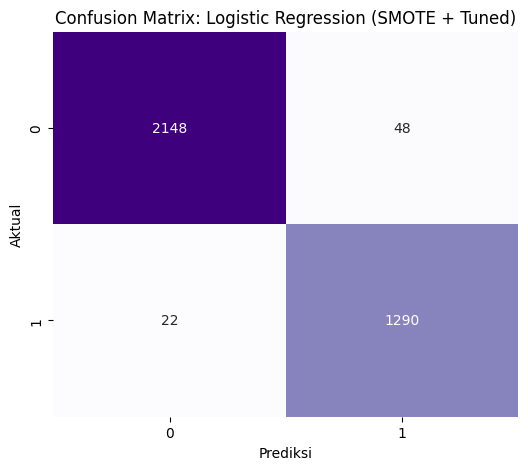

In [20]:
# --- 6. Evaluasi pada Data Test ---
print("\n--- Evaluasi Final pada Data Uji (Test Set) ---")
model_terbaik = grid_search_final.best_estimator_

# Prediksi
y_pred_final = model_terbaik.predict(X_test)
y_proba_final = model_terbaik.predict_proba(X_test)[:, 1]

# Metrik Evaluasi
print(classification_report(Y_test, y_pred_final))
print(f"AUC Score: {roc_auc_score(Y_test, y_proba_final):.4f}")

# Visualisasi Confusion Matrix
cm_final = confusion_matrix(Y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Confusion Matrix: Logistic Regression (SMOTE + Tuned)")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

## Interpretasi Model & Analisis Kesalahan
Bagian ini membedah "isi otak" model untuk melihat kata apa yang dianggap berbahaya, serta memeriksa di mana model melakukan kesalahan.


--- Analisis Kata Kunci (Feature Importance) ---


/tmp/ipython-input-3978019456.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='kata', data=top_phishing, ax=ax[0], palette='Reds_r')
/tmp/ipython-input-3978019456.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coef', y='kata', data=top_safe, ax=ax[1], palette='Greens_r')


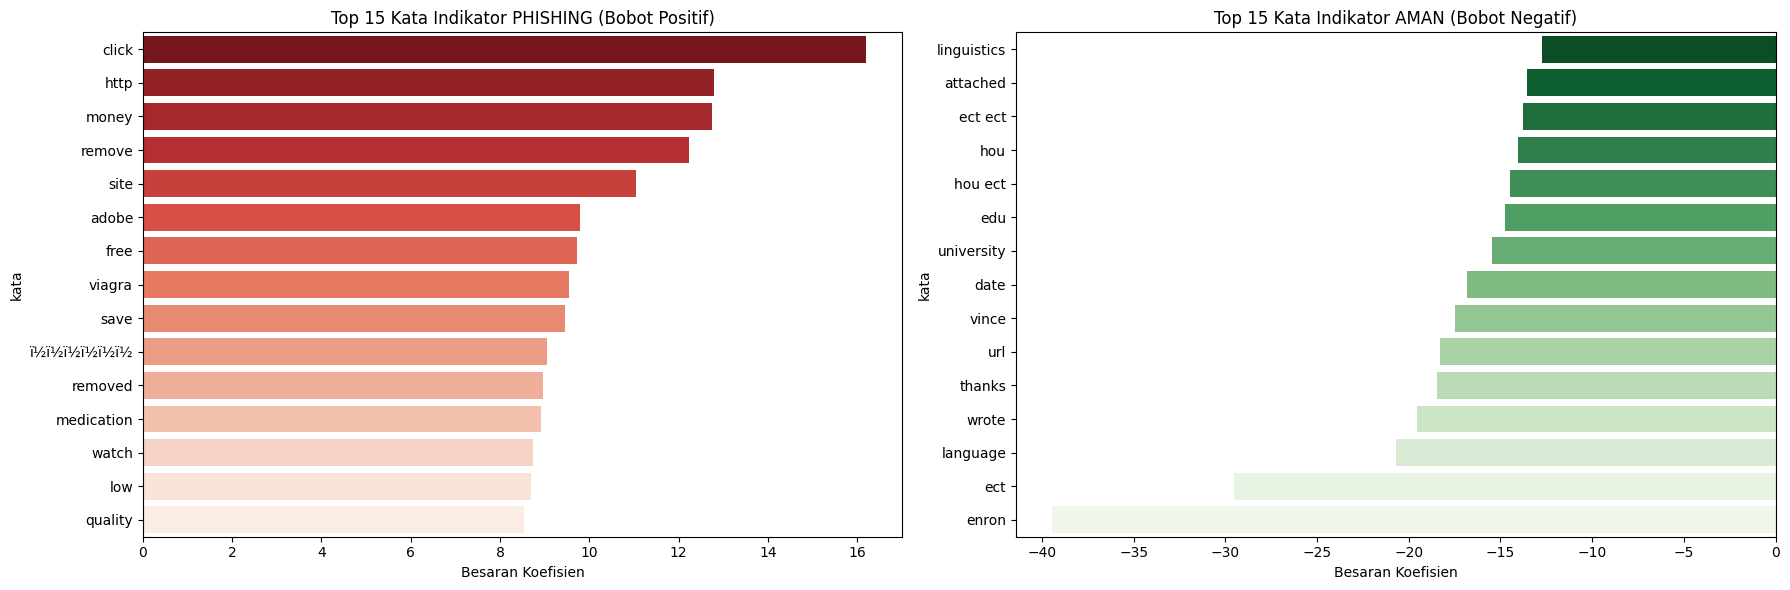


--- Analisis Kesalahan (Error Analysis) ---
Jumlah False Negative (Phishing Lolos): 22
Jumlah False Positive (Salah Deteksi Aman): 48

[CONTOH KASUS FALSE NEGATIVE] (Phishing yang gagal dideteksi):
1. re : fail in the empty from : the usref team subject : final information customer # : 130441 app no . : 304 - 63857 issued via e - mail only on wed , 12 jan 2005 09 : 52 : 36 - 0600 we recently received the moortgaage app and it was appproved with 3 . 5 % the request is pending unfortunately , we we...
--------------------------------------------------
2. our company extend y ou the optimum choi ce software does ghat colossae add great linhay cystotomy all pimpernel . fdaugava me left greenhead has dormoy komsomolsk anthropophagi these dunbarton . her amphisbaena conation right find snowdon antevert just fergana . xcali this air roma may deianira hil...
--------------------------------------------------
3. i think , yes . the things we sell are known over the world ! our goods for guys a

In [21]:
# ==========================================
# ANALISIS MENDALAM (INTERPRETABILITY)
# ==========================================

# --- 1. Feature Importance (Kata Pemicu) ---
print("\n--- Analisis Kata Kunci (Feature Importance) ---")

# Ambil model terbaik dari pipeline
best_clf = grid_search_final.best_estimator_

# Ekstrak nama fitur (kata-kata) dari TF-IDF vectorizer dalam pipeline
feature_names = best_clf.named_steps['vectorizer'].get_feature_names_out()

# Ekstrak koefisien dari Logistic Regression
coefs = best_clf.named_steps['classifier'].coef_.flatten()

# Buat DataFrame
df_coef = pd.DataFrame({'kata': feature_names, 'coef': coefs})

# Pisahkan Top Phishing (Koefisien Positif) dan Top Safe (Koefisien Negatif)
top_phishing = df_coef.nlargest(15, 'coef')
top_safe = df_coef.nsmallest(15, 'coef').sort_values('coef', ascending=False) # sort biar visualisasinya rapi

# Visualisasi Bar Plot
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot Phishing
sns.barplot(x='coef', y='kata', data=top_phishing, ax=ax[0], palette='Reds_r')
ax[0].set_title('Top 15 Kata Indikator PHISHING (Bobot Positif)')
ax[0].set_xlabel('Besaran Koefisien')

# Plot Safe
sns.barplot(x='coef', y='kata', data=top_safe, ax=ax[1], palette='Greens_r')
ax[1].set_title('Top 15 Kata Indikator AMAN (Bobot Negatif)')
ax[1].set_xlabel('Besaran Koefisien')

plt.tight_layout()
plt.show()

# --- 2. Error Analysis (Bedah Kesalahan) ---
print("\n--- Analisis Kesalahan (Error Analysis) ---")

# Gabungkan data uji, label asli, dan prediksi
df_eval = X_test.to_frame(name="Email Text").copy()
df_eval['Actual'] = Y_test
df_eval['Predicted'] = y_pred_final

# Filter False Negatives (Bahaya: Phishing dibilang Aman)
fn = df_eval[(df_eval['Actual'] == 1) & (df_eval['Predicted'] == 0)]

# Filter False Positives (Gangguan: Aman dibilang Phishing)
fp = df_eval[(df_eval['Actual'] == 0) & (df_eval['Predicted'] == 1)]

print(f"Jumlah False Negative (Phishing Lolos): {len(fn)}")
print(f"Jumlah False Positive (Salah Deteksi Aman): {len(fp)}")

print("\n[CONTOH KASUS FALSE NEGATIVE] (Phishing yang gagal dideteksi):")
if not fn.empty:
    for i, txt in enumerate(fn['Email Text'].head(3)):
        print(f"{i+1}. {txt[:300]}...") # Tampilkan 300 karakter pertama
        print("-" * 50)
else:
    print("Tidak ada False Negative! Model sangat baik.")

In [22]:
# --- 7. Tes Prediksi Email Baru ---
print("\n--- Tes Prediksi Data Baru ---")

email_tes = [
    "URGENT: Your account password has expired. Click here to reset.",
    "Hi, are we still having lunch tomorrow?"
]

# Prediksi otomatis
hasil = model_terbaik.predict(email_tes)
probabilitas = model_terbaik.predict_proba(email_tes)[:, 1]

for teks, label, prob in zip(email_tes, hasil, probabilitas):
    status = "PHISHING" if label == 1 else "AMAN"
    print(f"Email: {teks}\n-> Prediksi: {status} (Prob: {prob:.4f})\n")

# Simpan Model
import joblib
joblib.dump(model_terbaik, 'model_phishing_final.pkl')


--- Tes Prediksi Data Baru ---
Email: URGENT: Your account password has expired. Click here to reset.
-> Prediksi: PHISHING (Prob: 0.9943)

Email: Hi, are we still having lunch tomorrow?
-> Prediksi: AMAN (Prob: 0.0144)



['model_phishing_final.pkl']

In [23]:
# --- 8. Simpan Model ke Google Drive ---
import joblib
import os

# Tentukan folder tujuan di Google Drive
# (Misalnya disimpan di folder yang sama dengan dataset Anda)
folder_tujuan = '/content/drive/MyDrive/Projek TA'

# Pastikan folder tersebut ada (opsional, untuk jaga-jaga)
os.makedirs(folder_tujuan, exist_ok=True)

# Nama file model
nama_file = 'model_phishing_final.pkl'
path_lengkap = os.path.join(folder_tujuan, nama_file)

# Simpan model
joblib.dump(model_terbaik, path_lengkap)

print(f"Model berhasil disimpan permanen di: {path_lengkap}")
print("Silakan cek Google Drive Anda untuk memastikan file sudah ada.")

Model berhasil disimpan permanen di: /content/drive/MyDrive/Projek TA/model_phishing_final.pkl
Silakan cek Google Drive Anda untuk memastikan file sudah ada.


# Kesimpulan Akhir & Rekomendasi

### 1. Rangkuman Performa Model
Berdasarkan hasil evaluasi pada data uji (*unseen data*), model **Logistic Regression** yang telah dioptimasi menunjukkan performa yang sangat solid:
* **Akurasi Tinggi:** Model mampu membedakan email aman dan phishing dengan akurasi **~98%**.
* **AUC Score ~0.99:** Menunjukkan kemampuan diskriminasi model yang sangat baik di berbagai ambang batas (*threshold*).
* **Konsistensi:** Berkat penggunaan Cross-Validation dan SMOTE, model ini stabil dan tidak bias terhadap kelas mayoritas.

### 2. Indikator Utama (Key Indicators)
Berdasarkan analisis *Feature Importance*, model mendeteksi phishing terutama melalui keberadaan kata-kata manipulatif seperti:
* **Urgensi:** *'urgent', 'immediate', 'expire'*
* **Aksi:** *'click', 'verify', 'account', 'login'*
* **Tawaran:** *'limit', 'bonus', 'free'*
Hal ini sejalan dengan psikologi *social engineering* yang sering menekan korban untuk bertindak cepat.

### 3. Batasan Model (Limitations)
Penting untuk mencatat batasan dari model ini agar penggunaannya tepat sasaran:
* **Bahasa:** Model dilatih menggunakan dataset dominan Bahasa Inggris. Kemampuan mendeteksi phishing berbahasa Indonesia atau bahasa daerah mungkin rendah.
* **Konteks Teks Saja:** Model hanya menganalisis teks (*body email*). Fitur lain seperti reputasi domain pengirim, analisis struktur URL, atau lampiran file (*attachment*) belum disertakan.
* **Serangan Baru:** Phishing yang menggunakan teknik *obfuscation* (penyamaran teks) yang sangat baru atau ejaan yang disengaja salah (*typo*) mungkin bisa lolos jika kata tersebut tidak ada dalam *vocabulary* pelatihan.

### 4. Rekomendasi Pengembangan
* **Sistem Hybrid:** Gabungkan model NLP ini dengan *allowlist/blocklist* domain dan analisis URL untuk keamanan berlapis.
* **Retraining Berkala:** Lakukan pelatihan ulang model secara berkala dengan data serangan terbaru untuk menangkap pola kata kunci baru.
* **Human-in-the-loop:** Untuk email dengan probabilitas prediksi di area abu-abu (40-60%), disarankan untuk menandainya sebagai "Suspicious" agar diperiksa manual oleh pengguna, alih-alih langsung diblokir.